## <center>Проект: Анализ ассортимента для интернет-магазина
---

#### <article id="back">
<h2> Навигация </h2>
</article>   
<br><a href="#part0.0">Задача</a>
<br><a href="#part1">Шаг 1. Загрузка и обзор общей информации о данных</a>
<br><a href="#part2">Шаг 2. Предобработка данных</a>
<br><a href="#part3">Шаг 3. Анализ данных</a>
<br><a href="#part4">Шаг 4. Кластеризация ассортимента</a>
<br><a href="#part5">Шаг 5. Проверка гипотез</a>
<br><a href="#part6">Шаг 6. Вывод и рекомендации</a>

<article id="part0.0">
<h2>Задача
</article>

Проанализировать ассортимент товаров для оптимизации рекомендаций покупателям и закупок: определить какие товары входят в основной, а какие в дополнительный ассортимент.

<a href="#back">В начало</a>

<article id="part1">
<h2>Шаг 1. Загрузка и обзор общей информации о данных
</article>

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np

from scipy import stats as st

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-deep')

import seaborn as sns

import re
import requests
from io import BytesIO 
from bs4 import BeautifulSoup

from time import sleep
from random import randint

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.metrics import silhouette_score

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
spreadsheet_id = '...'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
ecomm_sales = pd.read_csv(BytesIO(r.content))

In [3]:
def show_info(df):
    """
    Отображает первые 3 строки датафрейма, кол-во дубликатов и информацию о датафрейме
    """
    display(df.head(3))
    print('Кол-во полных дубликатов в данных:{}'.format(df.duplicated().sum()))
    print()
    display(df.info())
    display(df.describe(include = 'all'))

In [4]:
show_info(ecomm_sales)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00


Кол-во полных дубликатов в данных:0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


None

,date,customer_id,order_id,product,quantity,price
count,6737.00,6737,6737.00,6737,6737.00,6737.00
unique,nan,2451,nan,2343,nan,nan
top,nan,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,nan,Рассада Кабачка сорт Зебра кассета 6 шт E6,nan,nan
freq,nan,888,nan,79,nan,nan
mean,2018854551.37,NaN,43128.95,NaN,2.50,462.03
std,385518.47,NaN,27899.41,NaN,15.27,871.30
min,2018100100.00,NaN,12624.00,NaN,1.00,9.00
25%,2019020413.00,NaN,14827.00,NaN,1.00,101.00
50%,2019050216.00,NaN,68503.00,NaN,1.00,135.00
75%,2019061022.00,NaN,70504.00,NaN,1.00,398.00


Смотрим на данные в общем и предполагаем, на что стоит обратить внимание на предобработке:
- Всего доступно почти 7т записей о заказах в интернет-магазине (пропусков и полных дубликатов нет)
- Уникальных пользователей: 2451, то есть некоторые пользователи скорее всего совершили по несколько заказов
- Уникальных товаров (SKU): 2343
- Типы данных в целом корректны кроме типа в столбце `date` — судя по первым строкам, формат даты в столбце следующий: "ггггммддчч"
- В данных о кол-ве товаров в заказе и цене есть выбросы (максимальные значения во много раз превосходят средние и медианные) — посмотреть на них в следующих шагах
- Нам нужно сделать анализ ассортимента, но без категории товара, это сделать проблематично. Планирую ее парсить из открытых источников

<a href="#back">В начало</a>

<article id="part2">
<h2>Шаг 2. Предобработка данных
</article>

**Привожу тип данных в столбце `date`**

In [5]:
ecomm_sales['date'] = pd.to_datetime(ecomm_sales['date'], format='%Y%m%d%H')

In [6]:
print('min date', ecomm_sales['date'].min())
print('max date', ecomm_sales['date'].max())

min date 2018-10-01 00:00:00
max date 2019-10-31 16:00:00


Нам доступен годовой тренд продаж: самая ранняя дата в датасете — 2018-10-01, поздняя — 2019-10-31

Для следующих шагов в анализе добавляю для событий короткую дату, день недели и час.

In [7]:
ecomm_sales['date_short'] = ecomm_sales['date'].dt.normalize()
ecomm_sales['month'] = ecomm_sales['date'].values.astype('datetime64[M]')
ecomm_sales['weekday'] = ecomm_sales['date'].dt.weekday
ecomm_sales['hour'] = ecomm_sales['date'].dt.hour

<article id="duplicates">
<h4>Обработка дубликатов
    
</article>

Проверяю наличие неполных дубликатов — счиатю дубликатом строки, где совпадают все параметры кроме id пользователя, id заказа и названия продукта.

In [8]:
subset=['customer_id',
        'order_id',
        'product']

print('Кол-во дубликатов в данных:{}'.format(ecomm_sales.duplicated(subset=subset).sum()))

Кол-во дубликатов в данных:1886


In [9]:
ecomm_sales = ecomm_sales.drop_duplicates(subset=subset)

**Предобработка названий продуктов**

Убираю предлоги, любые английские буквы и слова, цифры и оставляю только первое слово из названия продукта

In [10]:
trash_di = '|'.join([' в ', ' по ', ' для ', ' с ', ' л ', ' см ', ' м ', ' мл ', ' из ', ' у ', ' к ', ' от ', ' на '])

In [11]:
ecomm_sales['product_1word'] = (ecomm_sales['product']
                                     .str.lower()
                                     .str.replace(trash_di, ' ')
                                     .map(lambda x: re.sub(r'[A-Za-z]+|[\d]+|[\W]', ' ', x))
                                     .map(lambda x: x.split(' ')[0])
                                    )
ecomm_sales = ecomm_sales[ecomm_sales['product_1word'] != ''].reset_index(drop=True)

**Парсинг категорий**

Ниже код для парсинга категорий товаров с сайта Castorama.

    `categories = [
                  'gardening-and-outdoor/gardening-tools',
                  'gardening-and-outdoor/seeds',
                  'gardening-and-outdoor/garden-plants-and-seedlings',
                  'gardening-and-outdoor/sauna',
                  'gardening-and-outdoor/houseplants',
                  'storage-and-household-goods/storage',
                  'storage-and-household-goods/cleaning', 
                  'storage-and-household-goods/aksessuary-dlja-stirki-sushki-i-uhoda',
                  'bathroom/bathroom-accessories'
                   ]
    pages = np.arange(1, 30, 1)
    product_data = []
    category_data = []

    for category in categories:
    
        for page in pages:
            URL = 'https://www.castorama.ru/{}?p={}'.format(category, page)
            req = requests.get(URL) 
            soup = BeautifulSoup(req.text, 'html.parser')
            main_div = soup.find('div', class_='category-products')
            prod_div = main_div.find_all('div', class_='product-name h3')
            sleep(randint(2,10))
        
            for row in prod_div:
                product_data.append(row.text.replace('\n',''))
                category_data.append(category.split('/')[1].replace('-', '_'))
            
    castorama_catalog = pd.DataFrame(data = product_data, columns = ['product'])
    castorama_catalog['category'] = category_data
    castorama_catalog.to_csv('castorama_catalog.csv', index = False, sep = ';')`

In [12]:
spreadsheet_id = '...'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
castorama_catalog = pd.read_csv(BytesIO(r.content))

Также как и для продуктов в исходном датасете, для каталога убираю предлоги, любые английские буквы и слова, цифры и оставляю только первое слово из названия продукта

In [13]:
castorama_catalog['product_1word'] = (castorama_catalog['product']
                                       .str.lower()
                                       .str.replace(trash_di, ' ')
                                       .map(lambda x: re.sub(r'[A-Za-z]+|[\d]+|[\W]', ' ', x))
                                       .map(lambda x: x.split(' ')[0])
                                      .map(lambda x: x.strip())
                                    )

castorama_catalog = castorama_catalog[castorama_catalog['product_1word'] != ''].reset_index()

Многим продуктам присвоены различные категорий: создаю словарь Название продукта-Категория. Категорию выбираю как наиболее часто встречающуюся для этого продукта. Затем нахожу соответсвие названия продукта в словаре и `ecomm_sales`.

In [14]:
prod_cat_dict = (castorama_catalog
                  .groupby(['product_1word', 'category'])
                  .agg(prod_number = ('product', 'count'))
                  .sort_values(by = ['prod_number'], ascending = False)
                  .reset_index()
                  .pivot_table(index = ['product_1word'], values = 'category', aggfunc = 'first')
                  .reset_index()
                 )

In [15]:
ecomm_sales = ecomm_sales.merge(prod_cat_dict[['product_1word', 'category']], on='product_1word', how='left')

Для удобства анализа посмотрим какие категории наиболее популярные и присоединим к ним похожие по теме, но менее популярные

In [16]:
(ecomm_sales
 .groupby('category')
 .agg(product_number = ('product', 'count'))
 .sort_values(by='product_number', ascending = False)
)

,product_number
category,
houseplants,917
aksessuary_dlja_stirki_sushki_i_uhoda,341
storage,266
bathroom_accessories,235
garden_plants_and_seedlings,211
cleaning,186
gardening_tools,61
sauna,20
seeds,20


In [17]:
cat_di = {'bathroom_accessories':'bathroom_acc', 
          'sauna':'bathroom_acc',
          'aksessuary_dlja_stirki_sushki_i_uhoda':'bathroom_acc',
          'garden_plants_and_seedlings':'garden_plants_and_acc',
          'gardening_tools':'garden_plants_and_acc',
          'seeds':'garden_plants_and_acc',
          'cleaning':'cleaning_and_storage',
          'storage':'cleaning_and_storage',
         }
ecomm_sales['category'] = ecomm_sales['category'].replace(cat_di)

Так гораздо удобнее: всего у нас осталось 4 категории: домашние растения, садовые растения, хранение и порядок и аксессуары для ванной).
Товары без категории объединю в other.

In [18]:
ecomm_sales.loc[ecomm_sales['category'].isna(), 'category'] = 'other'

In [19]:
prod_by_cat = (ecomm_sales
               .groupby('category')
               .agg(product_number = ('product', 'nunique'))
               .sort_values(by='product_number', ascending = False)
              )
print('Всего SKU:', prod_by_cat.sum()[0])
prod_by_cat

Всего SKU: 2340


,product_number
category,
other,837
garden_plants_and_acc,486
cleaning_and_storage,428
bathroom_acc,331
houseplants,258


Категория с наибольшим кол-вом SKU — Садовые растения и аксессуары, затем идут Хранение и Порядок, Аксессуары для Ванной и Домашние растения.

Далее для выводов в общем о продажах/сезонности и кол-ве покупателей буду использовать полный датасет со всеми категориями, в том числе other. А для распределений по категориям и кластеризации — датасет только с теми продуктами, которые удалось определить по категориям (`ecomm_sales_wo_other`)

In [20]:
ecomm_sales_wo_other = ecomm_sales[ecomm_sales['category'] != 'other']

**Обработка выбросов**

Посмотрим на распределение медианных цен за год и количества товаров в заказе, определим есть ли выбросы и если есть — удалим их.

95 и 99 персентили медианных цен за год: 2527, 5316


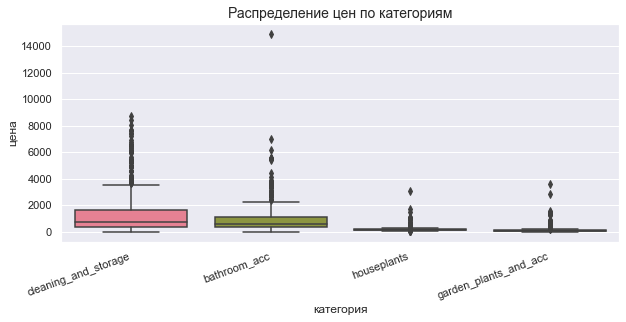

In [21]:
p95, p99 = np.percentile(ecomm_sales_wo_other['price'], [95, 99])
print('95 и 99 персентили медианных цен за год: {:.0f}, {:.0f}'.format(p95, p99))

sns.set(rc = {'figure.figsize': (10, 4)})

order_for_bars = (ecomm_sales_wo_other
                  .groupby(['category'], as_index = False)
                  .agg({'price': 'median'})
                  .sort_values(by = 'price', ascending = False)
                  .iloc[:, 0]
                 )

sns.boxplot(x = 'category',
            y = 'price',
            data = ecomm_sales_wo_other,
            palette = 'husl',
            order = order_for_bars
           )

plt.xticks(rotation=20, ha="right")
plt.title('Распределение цен по категориям', fontdict={'size':14})
plt.xlabel('категория')
plt.ylabel('цена');

Удаляю записи выше 99го персентиля цен, то есть продукты, дороже 4574\\$. Важно удалить выбросы, так как на этапе кластеризации есть большая вероятность выделить отдельную категорию из одного-двух продуктов просто потому что они слишком далеко от остальных по цене, но не по сути.

In [22]:
ecomm_sales = ecomm_sales[ecomm_sales['price'] < p99]
ecomm_sales_wo_other = ecomm_sales_wo_other[ecomm_sales_wo_other['price'] < p99]

95 и 99 персентили количества товаров в заказе: 5, 30


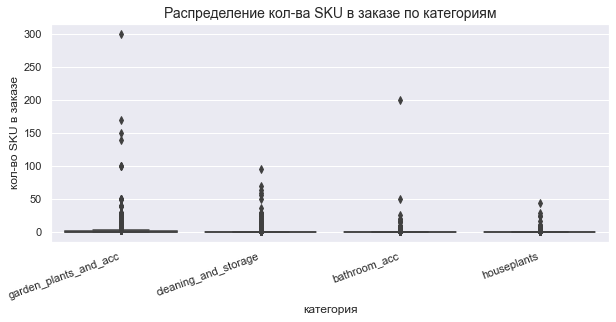

In [23]:
p95, p99 = np.percentile(ecomm_sales_wo_other['quantity'], [95, 99])
print('95 и 99 персентили количества товаров в заказе: {:.0f}, {:.0f}'.format(p95, p99))

sns.set(rc = {'figure.figsize': (10, 4)})

order_for_bars = (ecomm_sales_wo_other
                  .groupby(['category'], as_index = False)
                  .agg({'quantity': 'mean'})
                  .sort_values(by = 'quantity', ascending = False)
                  .iloc[:, 0]
                 )

sns.boxplot(x = 'category',
            y = 'quantity',
            data = ecomm_sales_wo_other,
            palette = 'husl',
            order = order_for_bars
           )

plt.xticks(rotation=20, ha="right")
plt.title('Распределение кол-ва SKU в заказе по категориям', fontdict={'size':14})
plt.xlabel('категория')
plt.ylabel('кол-во SKU в заказе');

Удаляю записи выше 99го персентиля кол-ва SKU в заказе, то есть заказы, в которых более 25 SKU

In [24]:
ecomm_sales = ecomm_sales[ecomm_sales['quantity'] < p99]
ecomm_sales_wo_other = ecomm_sales_wo_other[ecomm_sales_wo_other['quantity'] < p99]

**Общий вывод по предобработке**

- Ключевой задачей было распределить бОльшую часть продуктов по категориям. Для этого использовался каталог магазина Castorama и соответствие первых слов в названии продукта в каталоге и в исходном датасете.
- Из 2263 SKU не распределенными осталось 817 (36%). Возможно для лучшей эффективности, нужно было для большего кол-ва категорий парсить каталог или придумать другой способ нахождения соответствий. На данный момент я решила принять этот результат за удовлетворительный и перейти к анализу данных

<a href="#back">В начало</a>

<article id="part3">
<h2>Шаг 3. Анализ данных
    
</article>

Для следующий шагов добавляю расчетную выручку

In [25]:
ecomm_sales['revenue'] = ecomm_sales['quantity'] * ecomm_sales['price']
ecomm_sales_wo_other['revenue'] = ecomm_sales_wo_other['quantity'] * ecomm_sales_wo_other['price']

**Сколько всего пользователей, заказов, товаров у магазина?**

In [26]:
product_sales = ecomm_sales.groupby('month').agg(revenue = ('revenue', 'sum'),
                                                 quantity = ('quantity', 'sum'),
                                                 order_cnt = ('order_id', 'nunique'),
                                                 customer_cnt = ('customer_id', 'nunique')
                                                )
product_sales['avg_order_by_customer'] = product_sales['order_cnt'] /product_sales['customer_cnt']

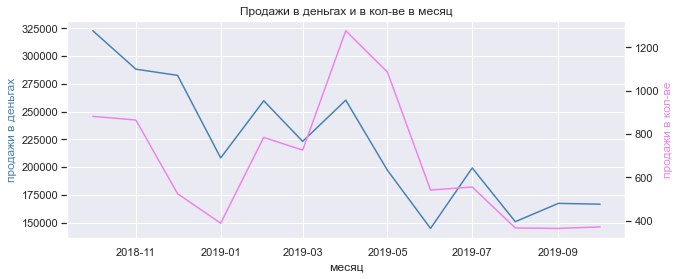

In [27]:
x = product_sales.index
y1 = product_sales['revenue']
y2 = product_sales['quantity']

fig, ax1 = plt.subplots(figsize = (10, 4))

ax1.plot(x, y1, color = 'steelblue')
ax1.set_xlabel('месяц')
ax1.set_ylabel('продажи в деньгах', color = 'steelblue')
ax1.set_title('Продажи в деньгах и в кол-ве в месяц')

ax2 = ax1.twinx() 
ax2.plot(x, y2, color = 'violet')
ax2.set_ylabel('продажи в кол-ве', color='violet')
ax2.grid(False);

Выручка интернет-магазина падает в течение года с \~370т\\$ в месяц в Октябре 2018 до \~200т\\$ в месяц в Октябре 2019. Тем не менее и по сумме, и по кол-ву продаж выделяется явный сезон с Апреля по Июнь — покупают растения домой и для дачи.

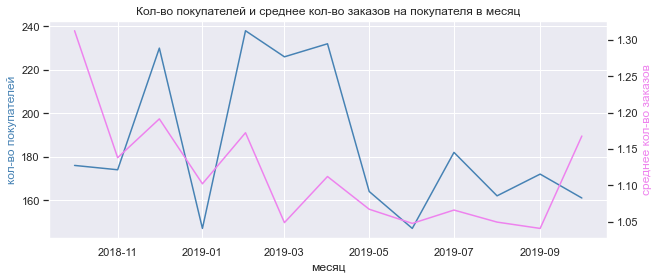

In [28]:
x = product_sales.index
y1 = product_sales['customer_cnt']
y2 = product_sales['avg_order_by_customer']

fig, ax1 = plt.subplots(figsize = (10, 4))

ax1.plot(x, y1, color = 'steelblue')
ax1.set_xlabel('месяц')
ax1.set_ylabel('кол-во покупателей', color = 'steelblue')
ax1.set_title('Кол-во покупателей и среднее кол-во заказов на покупателя в месяц')

ax2 = ax1.twinx() 
ax2.plot(x, y2, color = 'violet')
ax2.set_ylabel('среднее кол-во заказов', color='violet')
ax2.grid(False);

Оба показателя: и среднее кол-во уникальных покупателей, и кол-во заказов на покупателя в месяц имеют тенденцию к снижению в 2019г. 

**Сколько в среднем продуктов в заказе?**

95 и 99 персентили количества продуктов: 6.00, 14.12
В 118 заказах более 6.0 продуктов и в 27 более 14 продуктов
Среднее кол-во уникальных продуктов в заказах: 2


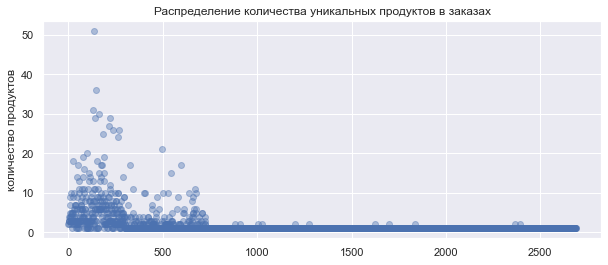

In [29]:
x = pd.Series(range(0, ecomm_sales['order_id'].nunique()))
y = ecomm_sales.groupby('order_id').agg(prod_number = ('product', 'nunique'))

order_per_95, order_per_99 = np.percentile(y['prod_number'], [95, 99])
users_above_per_95 = y[y['prod_number'] > order_per_95]['prod_number'].count()
users_above_per_99 = y[y['prod_number'] > order_per_99]['prod_number'].count()

print('95 и 99 персентили количества продуктов: {:.2f}, {:.2f}'.format(order_per_95, order_per_99))
print('В {:.0f} заказах более {} продуктов и в {:.0f} более {:.0f} продуктов'.format(users_above_per_95, order_per_95, users_above_per_99, order_per_99))
print('Среднее кол-во уникальных продуктов в заказах: {:.0f}'.format(y['prod_number'].mean()))

fig, ax = plt.subplots(figsize = (10, 4))
plt.scatter(x, y, alpha = 0.4)
plt.title('Распределение количества уникальных продуктов в заказах')
plt.ylabel('количество продуктов');


В среднем, люди покупают 2 разных продукта в заказе, но есть и заказы с 6 и 14 товарами. Это хорошо, значит можно попробовать повлять на пользователей корректными рекомендациями и еще больше расширить корзину

**Сколько всего товаров, как они распределены по категориям?**

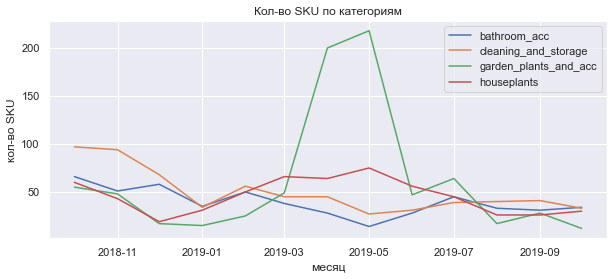

In [30]:
product_monthly = (ecomm_sales_wo_other
                   .pivot_table(index = 'month',
                                columns = 'category',
                                values = 'product',
                                aggfunc = 'nunique')
              )

plt.figure(figsize=(10, 4))
plt.title('Кол-во SKU по категориям')

plt.plot(product_monthly)
plt.legend(product_monthly.columns)
plt.ylabel('кол-во SKU')
plt.xlabel('месяц');

Значительно выделяется ассортимент категорий Садовые растения и Домашние растения в сезон (Апр-Май), в остальные месяцы ассортимент всех категорий сравним (~35 SKU в Окт'19) и имеет тенденцию к снижению в течение 2019г

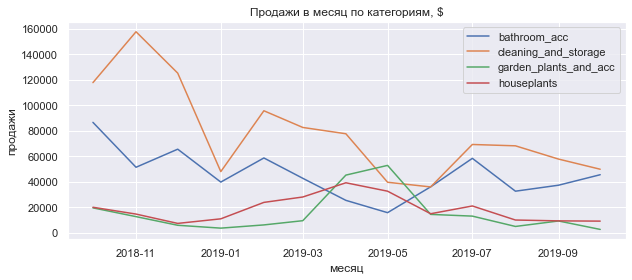

In [31]:
revenue_monthly = (ecomm_sales_wo_other
                   .pivot_table(index = 'month',
                                columns = 'category',
                                values = 'revenue',
                                aggfunc = 'sum')
                  )

plt.figure(figsize=(10, 4))
plt.title('Продажи в месяц по категориям, $')

plt.plot(revenue_monthly)
plt.legend(revenue_monthly.columns)
plt.ylabel('продажи')
plt.xlabel('месяц');

На выручке по категориям также виден сезон для садовых и домашних растений, по категории Садовые растения выручка растет с <20т\\$ в Марте до ~90т\\$ в Мае-Июне. В остальное время года больше всего выручки приносит категория Хранение и порядок.

**Общий вывод по анализу данных**

- Выручка интернет-магазина падает в течение 2019 года на ~45%, рост выручки и кол-ва SKU наблюдается только в сезон: с Апреля по Июнь — покупают растения домой и для дачи.
- Оба показателя: и среднее кол-во уникальных покупателей, и кол-во заказов на покупателя в месяц имеют тенденцию к снижению в 2019г. Очевидно, наш интернет-магазин выбирает неправильные каналы продвижения или ассортиментную политику.
- В среднем, люди покупают 2 разных продукта в заказе. Это хорошо, значит можно попробовать повлять на пользователей корректными рекомендациями и еще больше расширить корзину
- Значительно выделяется ассортимент и выручка категорий Садовые растения и Домашние растения в сезон Апр-Июнь. В остальные месяцы ассортимент всех категорий сравним (~35 SKU в Окт'19), а больше всего выручки приносит категория Хранение и порядок.

<a href="#back">В начало</a>

<article id="part4">
<h2>Шаг 4. Кластеризация ассортимента
</article>

Моя гипотеза о разделении продуктов на основной и доп ассортимент: товаров из основного ассортимента в заказазе должно быть в среднем меньше, чем из дополнительного и они должны быть дороже. Например для категории Аксессуары для ванной дорогая сушилка для белья — скорее всего основной ассортимент, а дешевые пластмассовые стаканы или мешки для мусора — дополнительный.

Планирую посмотреть на дендрограммах деление на кластеры по категориям (признаки: цена, кол-во SKU заказе) и затем разделить ассортимент, ориентируясь на них. 

In [32]:
prod_char = (ecomm_sales_wo_other
             .groupby('product')
             .agg(category = ('category', 'first'),
                  price = ('price', 'median'),
                  quantity = ('quantity', 'mean'))
             .reset_index()
            )

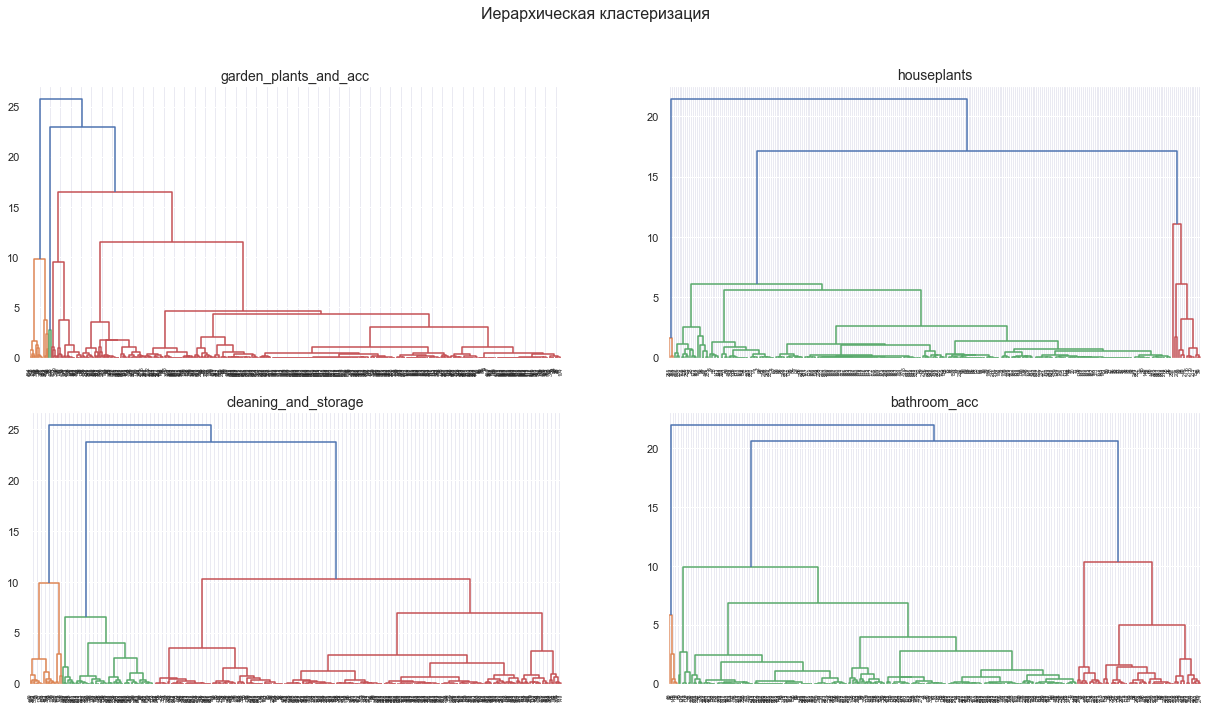

In [33]:
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
fig.set_size_inches(21, 11)

for i, category in enumerate(prod_char['category'].unique()):
    scaler = StandardScaler()
    data = prod_char.loc[prod_char['category'] == category]
    x_sc = scaler.fit_transform(data[['price', 'quantity']])
    
    #строим матрицу расстояний
    linked = linkage(x_sc, method = 'ward')

    #строим дендрограмму
    dendrogram(linked, ax = ax[i], orientation='top')
    plt.suptitle('Иерархическая кластеризация', fontsize = 16)
    ax[i].set_title(category, fontsize = 14);

По всем категориям выделяется 3 кластера. Разделю данные по кластерам и выведу статистику по ним.

In [34]:
prod_char_clusters = pd.DataFrame(data = [[np.nan,np.nan,np.nan,np.nan,np.nan]],
                                  columns = ['product', 'category', 'price', 'quantity', 'cluster'])

for category in prod_char['category'].unique():
    category_clusters = prod_char[prod_char['category'] == category].copy()
    
    #задаём модель и число кластеров
    scaler = StandardScaler()
    x_sc = scaler.fit_transform(category_clusters[['price', 'quantity']])
    linked = linkage(x_sc, method = 'ward')
    
    #прогнозируем кластеры
    k=3
    cluster = fcluster(linked, k, criterion='maxclust')
    category_clusters['cluster'] = cluster
    prod_char_clusters = prod_char_clusters.append(category_clusters)
    
prod_char_clusters = prod_char_clusters.dropna().reset_index()
prod_char_clusters['cluster'] = prod_char_clusters['cluster'].astype('int')

In [35]:
for category in prod_char_clusters['category'].unique():
    print('Средние значения признаков по кластерам в категории', category)
    display(prod_char_clusters[prod_char_clusters['category'] == category]
     .groupby('cluster')
     .agg(median_price = ('price', 'median'),
          mean_quantity = ('quantity', 'mean'),
          SKU_number = ('product', 'nunique')
         )
     .style
     .format("{:.1f}")
     .background_gradient(cmap = 'Blues', axis=0)
    )

Средние значения признаков по кластерам в категории garden_plants_and_acc


,median_price,mean_quantity,SKU_number
cluster,,,
1,54.8,12.1,18.0
2,3224.0,1.0,2.0
3,101.0,1.6,461.0


Средние значения признаков по кластерам в категории houseplants


,median_price,mean_quantity,SKU_number
cluster,,,
1,112.0,26.3,3.0
2,157.0,1.3,241.0
3,824.5,1.3,14.0


Средние значения признаков по кластерам в категории cleaning_and_storage


,median_price,mean_quantity,SKU_number
cluster,,,
1,94.0,13.3,25.0
2,3112.0,1.1,69.0
3,464.0,1.4,306.0


Средние значения признаков по кластерам в категории bathroom_acc


,median_price,mean_quantity,SKU_number
cluster,,,
1,195.5,12.1,6.0
2,565.5,1.3,242.0
3,1874.0,1.1,75.0


Видно, что кластеры значительно различаются по средней цене и кол-ву в заказе: в каждой категории есть кластер товаров с высокой ценой и небольшим кол-вом в заказе и низкой ценой и большим кол-вом в заказе. Третий кластер со средней ценой в большинстве случаев содержит очень мало наблюдений, думаю стоит объединить 3 и 2 кластеры, чтобы выделить отдельный кластер товаров с высокой ценой.

In [36]:
prod_char_clusters = prod_char_clusters.reset_index()
prod_char_clusters.loc[prod_char_clusters['cluster'] == 3, 'cluster'] = 2

In [37]:
prod_char = prod_char.merge(prod_char_clusters[['product', 'cluster']], on='product', how='left')

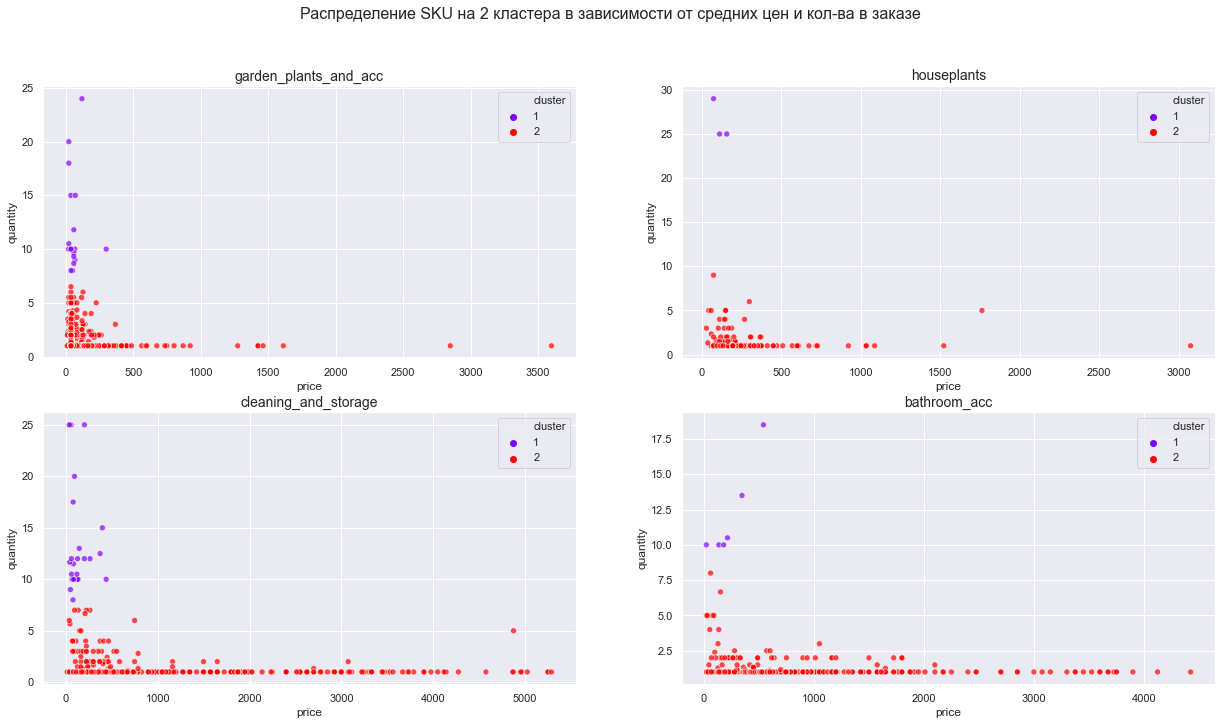

In [38]:
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
fig.set_size_inches(21, 11)
for i, category in enumerate(prod_char['category'].unique()):
    
    scatter = prod_char.loc[prod_char['category'] == category][['price', 'quantity', 'cluster']]
    sns.scatterplot(data=scatter,
                    x="price",
                    y="quantity",
                    hue = 'cluster',
                    ax = ax[i],
                    alpha = 0.7,
                    palette = 'rainbow',
                    legend = 'full')

    plt.suptitle('Распределение SKU на 2 кластера в зависимости от средних цен и кол-ва в заказе', fontsize = 16)
    ax[i].set_title(category, fontsize = 14);

На этапе Кластеризации мы выделили 2 основных кластера: с низкой ценой и большим количеством товаров в заказе, с высокой ценой и небольшим количеством товаров.

<a href="#back">В начало</a>

<article id="part5">
<h2>Шаг 5. Проверка гипотез
</article>

Проверяем гипотезу о том, что средняя цена по группам основного и дополнительного ассортимента внутри каждой категории статистически значимо различается.

H0 - средняя цена по группам основного и дополнительного ассортимента не отличается

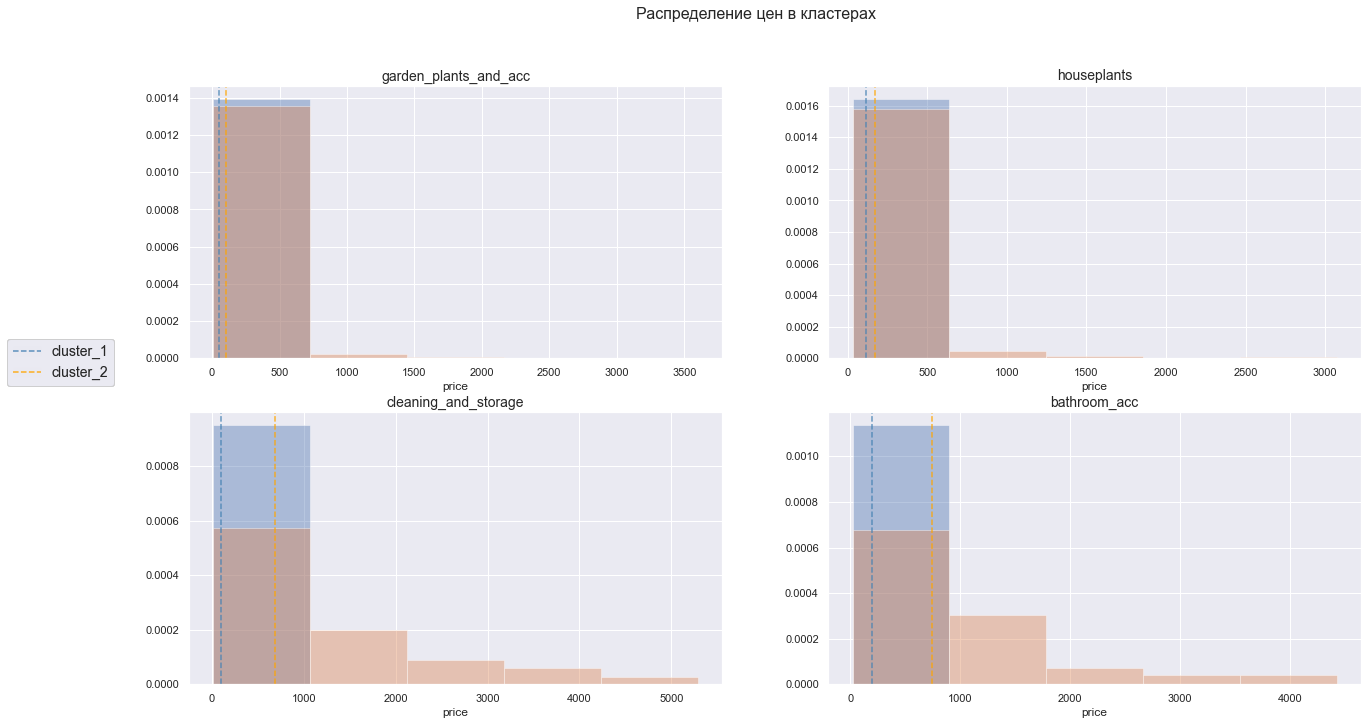

In [39]:
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
fig.set_size_inches(21, 11)

for i, category in enumerate(prod_char['category'].unique()):
    a = prod_char[(prod_char['category'] == category) & (prod_char['cluster'] == 1)]['price']
    b = prod_char[(prod_char['category'] == category) & (prod_char['cluster'] == 2)]['price']

    min_max = (prod_char[prod_char['category'] == category]['price'].min(), prod_char[prod_char['category'] == category]['price'].max())
    
    sns.distplot(a,
                 ax = ax[i],
                 kde = False,
                 bins = 5,
                 norm_hist = True,
                 hist_kws={"range": min_max}
               )
    sns.distplot(b,
                 ax = ax[i],
                 kde = False,
                 bins = 5,
                 norm_hist = True,
                 hist_kws={"range": min_max}
               )
    fig.legend(labels=['cluster_1','cluster_2'], loc = 'center left', fontsize = 14)
    
    ax[i].axvline(a.median(), color='steelblue', alpha=0.8, linestyle='dashed', label = 'cluster_1_expensive')
    ax[i].axvline(b.median(), color='orange', alpha=0.8, linestyle='dashed', label = 'cluster_2_cheap')

    plt.suptitle('Распределение цен в кластерах', fontsize = 16)
    ax[i].set_title(category, fontsize = 14);

In [40]:
print("Гипотезу о равенстве средних значений будем проверять с помощью T-test")
print()

for category in prod_char['category'].unique():
    alpha = 0.05 / len(prod_char['category'].unique())
    
    a = prod_char[(prod_char['category'] == category) & (prod_char['cluster'] == 1)]['price']
    b = prod_char[(prod_char['category'] == category) & (prod_char['cluster'] == 2)]['price']
    
    print("Категория", category)
    ttest_res = st.ttest_ind(a, b)
    
    if (ttest_res.pvalue < alpha):
        print("Значение p-value низкое, поэтому гипотезу о равенстве цен отвергаем (p-value = {:.4f})".format(ttest_res.pvalue))
    else:
        print("Не отвергаем гипотезу о равенстве средних цен в кластере 1 и кластере 2 (p-value = {:.4f})".format(ttest_res.pvalue))
    print()

Гипотезу о равенстве средних значений будем проверять с помощью T-test

Категория garden_plants_and_acc
Не отвергаем гипотезу о равенстве средних цен в кластере 1 и кластере 2 (p-value = 0.2036)

Категория houseplants
Не отвергаем гипотезу о равенстве средних цен в кластере 1 и кластере 2 (p-value = 0.4535)

Категория cleaning_and_storage
Значение p-value низкое, поэтому гипотезу о равенстве цен отвергаем (p-value = 0.0000)

Категория bathroom_acc
Не отвергаем гипотезу о равенстве средних цен в кластере 1 и кластере 2 (p-value = 0.0412)



Мы проверяли гипотезу о том, что средняя цена по группам основного и дополнительного ассортимента внутри каждой категории статистически значимо различается.

Мы не можем отвергнуть гипотезу о равенстве уен для большинства категорий (garden_plants_and_acc, houseplants, bathroom_acc). То есть разлиция в ценах между кластерами статистически не значимы. Только по категории cleaning_and_storage гипотеза о равенстве цен отвергнута.

По проверке гипотез есть несколько нюансов, из-за которых нужно интерпретировать результаты с осторожностью:
- кол-во наблюдений в Кластере 1 слишком маленькое (<50)
- стоит дополнительно проверить дисперсию по группам

<a href="#back">В начало</a>

<article id="part6">
<h2>Шаг 6. Общий вывод
</article>

Общий вывод по анализу торгового ассортимента и проверке гипотез.

**Анализ данных**
- Выручка интернет-магазина падает в течение 2019 года на ~45%, рост выручки и кол-ва SKU наблюдается только в сезон: с Апреля по Июнь.
- Среднее кол-во уникальных покупателей, и кол-во заказов на покупателя в месяц имеют тенденцию к снижению в 2019г. Очевидно, наш интернет-магазин выбирает неправильные каналы продвижения или ассортиментную политику.
- В среднем, люди покупают 2 разных продукта в заказе. Это хорошо, значит можно попробовать повлять на пользователей корректными рекомендациями и еще больше расширить корзину

**Кластеризация**
- На этапе Кластеризации мы выделили 2 основных кластера: с низкой ценой и большим количеством товаров в заказе, с высокой ценой и небольшим количеством товаров. Однако различия в ценах между кластерами статистически не подтвердились.